In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("data\\Classification\\NLS_Group24.txt", names = ['f1','f2'], sep = " ", index_col=False)

data_c1 = data.iloc[:300,:] # 300
data_c2 = data.iloc[300:800,:] # 500
data_c3 = data.iloc[800:1800,:] # 1000

data_c1.insert(loc=0, column='1', value=[1 for i in range(len(data_c1))])
data_c2.insert(loc=0, column='1', value=[1 for i in range(len(data_c2))])
data_c3.insert(loc=0, column='1', value=[1 for i in range(len(data_c3))])
data_c1.insert(loc=3, column='y', value=[0 for i in range(len(data_c1))])
data_c2.insert(loc=3, column='y', value=[1 for i in range(len(data_c2))])
data_c3.insert(loc=3, column='y', value=[2 for i in range(len(data_c3))])

train_c1 = data_c1.iloc[:180, :] # 180
train_c2 = data_c2.iloc[:300, :] # 300
train_c3 = data_c3.iloc[:600, :] # 600

val_c1 = data_c1.iloc[180:240, :] # 60
val_c2 = data_c2.iloc[300:400, :] # 100
val_c3 = data_c3.iloc[600:800, :] # 200

test_c1 = data_c1.iloc[240:, :] # 60
test_c2 = data_c2.iloc[400:, :] # 100
test_c3 = data_c3.iloc[800:, :] # 200

train = pd.concat([train_c1, train_c2, train_c3], ignore_index=True).sample(frac=1).reset_index(drop=True)
val = pd.concat([val_c1, val_c2, val_c3], ignore_index=True).sample(frac=1).reset_index(drop=True)
test = pd.concat([test_c1, test_c2, test_c3], ignore_index=True).sample(frac=1).reset_index(drop=True)

In [3]:
class twoL_nn:
    
    def __init__(self, layer_sizes, learning_rate, num_epochs):
        self.input_size = layer_sizes[0]
        self.h1 = layer_sizes[1]
        self.h2 = layer_sizes[2]
        self.k = layer_sizes[-1]
        self.params = self.initialize_params()
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        
    def sigmoid(self, z):
        return 1/(1 + np.exp(-z))

    def loss(self, y, s):
        return np.square(y - s)/2 

    def initialize_params(self):
        params = dict()
        params['W1'] = np.random.randn(self.h1, self.input_size)
        params['W2'] = np.random.randn(self.h2, self.h1+1)
        params['W3'] = np.random.randn(self.k, self.h2+1)
        return params

    def forward(self, x):
        W1, W2, W3 = self.params['W1'], self.params['W2'], self.params['W3']
        cache = dict()
        cache['A1'] = np.dot(W1, x)
        cache['H1'] = self.sigmoid(cache['A1'])
        cache['H1'] = np.append([[1]], cache['H1'], axis=0)
        cache['A2'] = np.dot(W2, cache['H1'])
        cache['H2'] = self.sigmoid(cache['A2'])
        cache['H2'] = np.append([[1]], cache['H2'], axis=0)
        cache['A3'] = np.dot(W3, cache['H2'])
        cache['H3'] = self.sigmoid(cache['A3'])
        return cache['H3'], cache

    def backward(self, x, y):
        s, cache = self.forward(x)
        
        dell3 = (y - s) * s * (1 - s) # k x 1
        dW3 = self.learning_rate * np.dot(dell3, cache['H2'].T) # k x j+1
        self.params['W3'] = self.params['W3'] + dW3 # k x j+1

        dell2 = np.dot(self.params['W3'][:, :-1].T, dell3) * cache['H2'][1:] * (1 - cache['H2'][1:]) # j x 1
        dW2 = self.learning_rate * np.dot(dell2, cache['H1'].T) # j x i+1
        self.params['W2'] = self.params['W2'] + dW2 # j x i+1
        
        dell1 = np.dot(self.params['W2'][:, :-1].T, dell2) * cache['H1'][1:] * (1 - cache['H1'][1:]) # i x 1
        dW1 = self.learning_rate * np.dot(dell1, x.T) # i x m
        self.params['W1'] = self.params['W1'] + dW1 # i x m
        
        return self.loss(y, s)

    def epoch(self, train):
        E = []
        for i in range(train.shape[0]):
            y = np.zeros((self.k, 1))
            y[train['y'][i]][0] = 1
            x = np.array(train.iloc[i, :-1]).reshape((self.input_size, 1))
            e = self.backward(x, y)
            E.append(e)

        return np.mean(E)

    def fit(self, train):
        history = []
        for i in range(1, self.num_epochs + 1):
            E = self.epoch(train)
            history.append(E)
        return history
    
    def predict(self, test):
        preds = np.zeros(test.shape[0])
        for i in range(test.shape[0]):
            pred, _ = self.forward(np.array(test.iloc[i, :-1]).reshape((3, 1)))
            preds[i] = np.argmax(pred)
        return preds

In [4]:
input_size = 3
layer_sizes = [3, 8, 8, 3]
learning_rate, num_epochs = 0.1, 100 
model = twoL_nn(layer_sizes, learning_rate, num_epochs)

history = model.fit(train)

In [5]:
x = np.linspace(-6, 6, 200)
y = np.linspace(-6, 6, 200)
xm, ym = np.meshgrid(x, y)
mesh = pd.DataFrame()
mesh['1'] = [1 for i in range(40000)]
mesh['f1'] = xm.reshape((40000, 1))
mesh['f2'] = ym.reshape((40000, 1))
mesh['pred'] = [1 for i in range(40000)]
mesh['pred'] = model.predict(mesh).astype(int)

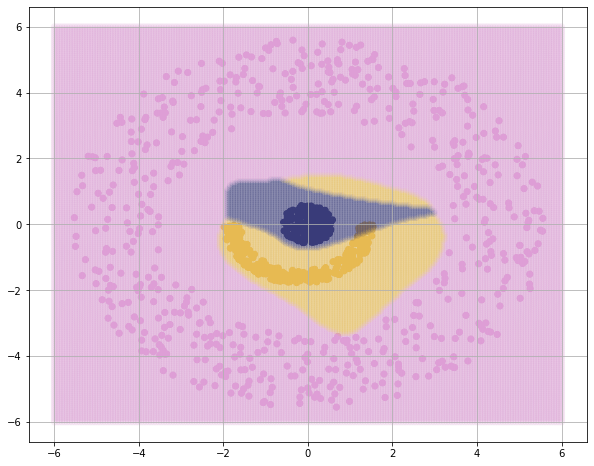

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
plt.scatter(train.f1, train.f2, c=train.y, cmap='tab20b')
plt.scatter(mesh.f1, mesh.f2, c=mesh.pred, alpha=0.1, cmap='tab20b')
plt.grid()